### Se declaran los paquetes a usar:

In [79]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Se llenara una matriz con los posibles viajes:

In [80]:
def posibles_viajes(individuos, columnas):

    p = np.zeros((individuos, columnas))
    for i in range(individuos):
        ciudades = ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                     11, 12, 13, 14, 15, 16, 17])
        for j in range(columnas):
            cd_al_azar = random.choice(ciudades)
            p[i][j] = cd_al_azar
            ciudades.remove(cd_al_azar)
    return p

### se calcula la distancia total del viaje sumando las dist entre cada ciudad de la matriz posibles_viajes:

In [81]:
def distancias(viajes, dist, individuos, columnas):
    
    dist_del_viaje = np.zeros((individuos, 1))
    for i in range(individuos):
        suma_de_dist = 0
        for j in range(columnas - 1):
            cd = int(viajes[i][j])
            cd_sig = int(viajes[i][j + 1])
            cd_in = int(viajes[i][0])
            cd_fin = int(viajes[i][17])
            suma_de_dist += dist[cd][cd_sig]
            dist_del_viaje[i][0] = suma_de_dist + dist[cd_in][cd_fin]
    return dist_del_viaje

### se ordenan las matrices de dist y viajes por su aptitud:

In [82]:
def ordenamiento(dist_de_viaje, viajes):
    
    dist_ord = np.copy(dist_de_viaje)
    viajes_ord = np.copy(viajes)
    for i in range(len(dist_ord)):
        for j in range(len(dist_ord) - 1):
            if abs(dist_ord[j, 0]) < abs(dist_ord[j + 1, 0]):
               
                dist_ord[j, 0], dist_ord[j + 1, 0] = \
                dist_ord[j + 1, 0], dist_ord[j, 0]
                
                viajes_ord[[j], :], viajes_ord[[j + 1], :] = \
                viajes_ord[[j + 1], :], viajes_ord[[j], :]
    return dist_ord[::-1], viajes_ord[::-1]

###  se da el cruce con el método de heuristic crossover:

In [83]:
def cruce(viajes_ordenados,individuos,dist, cant_padres):
    
    #viajes[cota_sup:cota_inf]
    padres = viajes_ordenados[:cant_padres]
    
    # los mejores tienen más posibilidad de ser padres
    a = random.randrange(1,101)
    b = random.randrange(1,101)
    
    if a < 51:
        padre_1 = padres[random.randrange(0, int(cant_padres*.1))].astype(int)
    elif 51 <= a < 81:
        padre_1 = padres[random.randrange(int(cant_padres*.1), int(cant_padres*.4))].astype(int)
    elif 81 <= a <101:
        padre_1 = padres[random.randrange(int(cant_padres*.4), cant_padres)].astype(int)
        
    if b < 51:
        padre_2 = padres[random.randrange(0, int(cant_padres*.1))].astype(int)
    elif 51 <= b < 81:
        padre_2 = padres[random.randrange(int(cant_padres*.1), int(cant_padres*.4))].astype(int)
    elif 81 <= b <101:
        padre_2 = padres[random.randrange(int(cant_padres*.4), cant_padres)].astype(int)
        
    #creamos una copia de los padres, ya que al final aplicaremos elitismo
    #y los padres no deben ser editados para poder ser comparados con los hijos
    temp_padre_1 = 1 * padre_1
    temp_padre_2 = 1 * padre_2
    hijos = np.zeros((2,18))
    
    #comienza heuristic crossover:
    k = 0
    while (k < 2):
        n = random.randrange(0,18)
        x = np.where(temp_padre_1==n)[0]
        y = np.where(temp_padre_2==n)[0]
        
        temp_padre_1 = np.roll(temp_padre_1, -x)
        temp_padre_2 = np.roll(temp_padre_2, -y)
        
        hijo = np.zeros_like(padre_1)
        hijo[0] = n
        
        for i in range(0,17):
            dist_1 = dist[temp_padre_1[i]][temp_padre_1[i+1]]
            dist_2 = dist[temp_padre_2[i]][temp_padre_2[i+1]]
            if dist_1 < dist_2:
                hijo[i+1] = temp_padre_1[i+1]
                
                j = (i+1)
                v = np.where(temp_padre_2 == temp_padre_1[i+1])[0]
                w = np.split(temp_padre_2,[i+1])
                x = np.roll(w[1], -(v-j))
                temp_padre_2 = np.concatenate((w[0],x))    
            elif dist_1 > dist_2:
                hijo[i+1] = temp_padre_2[i+1]
                
                j = (i+1)
                v = np.where(temp_padre_1 == temp_padre_2[i+1])[0]
                w = np.split(temp_padre_1,[i+1])
                x = np.roll(w[1], -(v-j))
                temp_padre_1 = np.concatenate((w[0],x))   
            elif dist_1 == dist_2:
                hijo[i+1] = temp_padre_1[i+1]
        
        hijos[k] = hijo
        
        k += 1
        
    # debo hacer lo siguiente para porder concatenarlos como renglones por
    # separado, si no los une como un solo vector
    padre_1 = np.reshape(padre_1, (-1,1))
    padre_2 = np.reshape(padre_2, (-1,1))
    hijo = np.reshape(hijo, (-1,1))      
         
    padre_1 = padre_1.transpose()
    padre_2 = padre_2.transpose()
    hijo = hijo.transpose()
    
    # se crea una matriz con los padres e hijos
    padres_hijos = np.concatenate((padre_1, padre_2, hijos))
    
    return padres_hijos

 ### se da el cruce con el método de heuristic crossover

In [84]:
def mejores(padres_hijos, dist, individuos, columnas): 
    
    dist_fam = distancias(padres_hijos, dist, individuos, columnas)
    dist_fam_ordenadas, familia_ord = ordenamiento(dist_fam, padres_hijos)
    mejores = familia_ord[:2,:] 
    
    return mejores

### se llena una matriz con los los más aptos del cruce y elitismo:

In [85]:
def generacion(elitismo, viajes, l, sig_generación):
    
    sig_generacion[l] = elitismo[0]
    sig_generacion[l+1] = elitismo[1]
    
    return sig_generacion

### se hace la mutación de mi población que elijo para ser padres:

In [86]:
def mutacion(viajes_ordenados, individuos, cant_padres):
    
    # solo mutare a los individuos por debajo de la mitad:
    cota_inf = cant_padres//2
    candidatos = viajes_ordenados[cota_inf:cant_padres]
    
    num_ind = np.arange(cant_padres - cota_inf)
    num_ind = list(num_ind)
    
    # se elije el porcentaje de mutación
    for i in range(int((cant_padres)*.51)):
        ciudades = ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                     11, 12, 13, 14, 15, 16, 17])
        selec = random.choice(num_ind)
        num_ind.remove(selec)
        mutado = candidatos[selec]
        for j in range(3):
            a = random.choice(ciudades)
            ciudades.remove(a)
            b = random.choice(ciudades)
            ciudades.remove(b)
            mutado[a], mutado[b] = mutado[b], mutado[a]
        
        viajes_ordenados[cota_inf + selec] = mutado

    return viajes_ordenados

### A partir de aqui comienza en realidad a correr el programa porque lo anterior solo era la declaración de funciones, y lo subsecuente es la llamada de estas funciones:

In [98]:
dist = np.genfromtxt('distancias.csv', delimiter=' , ')
columnas = 18
individuos = 100
k = 0
generaciones = 50

# población inicial:
viajes = posibles_viajes(individuos, columnas)
dist_del_viaje = distancias(viajes, dist, individuos, columnas)
dist_ordenadas, viajes_ordenados = ordenamiento(dist_del_viaje, viajes)

# desendencia: 
sig_generacion = np.zeros_like(viajes)
mas_aptos = np.zeros((generaciones,1))
menos_aptos = np.zeros((generaciones,1))

# defino el numero individuos que tomo para que tengan hijos
cant_padres = individuos//2

while (k < generaciones):
    for l in range(0, individuos, 2):
        # generamos la matriz con los dos padres y dos hijos:
        padres_hijos = cruce(viajes_ordenados,individuos,dist, cant_padres)
        # elejimos a los dos mejores de la matriz padres_hijos:
        elitismo = mejores(padres_hijos, dist, 4, columnas) 
        # llenamos la matriz desendencia con los individuos selecc. por elitismo
        desendencia = generacion(elitismo, viajes,l, sig_generacion)

    # volvemos a ordenarlos por aptitud:    
    dist_del_viaje = distancias(desendencia, dist, individuos, columnas)
    dist_ordenadas, viajes_ordenados = ordenamiento(dist_del_viaje, desendencia)
    
    # guardamos al mejor y al peor de cada generacion
    mas_aptos[k] = dist_ordenadas[0]
    menos_aptos[k] = dist_ordenadas[individuos//4*3]
    
    # mutamos la actual población:
    viajes_ordenados = mutacion(viajes_ordenados, individuos, cant_padres)
    #volvemos a ordenarlos después de la solucion:
#    dist_del_viaje = distancias(viajes_ordenados, dist, individuos, columnas)
#    dist_ordenadas, viajes_ordenados = ordenamiento(dist_del_viaje, viajes_ordenados)

    k += 1

### Imprimimos la menor distancia , junto con el correspondiente individuo

In [99]:
dist_ordenadas[0], viajes_ordenados[0]

(array([ 23932.46]),
 array([  2.,  11.,  13.,   7.,   8.,   5.,   0.,   6.,   3.,   9.,  14.,
         17.,   1.,   4.,  12.,  16.,  15.,  10.]))

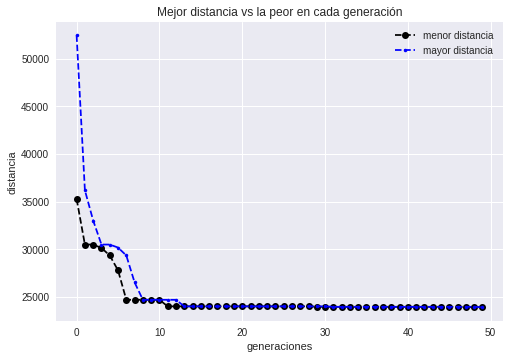

In [137]:
plt.style.use('seaborn-darkgrid')
plt.title("Mejor distancia vs la peor en cada generación")
plt.xlabel("generaciones")
plt.ylabel("distancia")
plt.plot(mas_aptos, marker = "o", linestyle = "--", color = "k", label = "menor distancia")
plt.plot(menos_aptos, marker = ".", linestyle = "--", color = "b", label = "mayor distancia")
plt.legend()

In [121]:
print(plt.style.available)

['seaborn-bright', 'fivethirtyeight', 'seaborn-darkgrid', 'seaborn-notebook', 'seaborn-ticks', 'classic', 'ggplot', 'seaborn', 'bmh', 'seaborn-deep', 'seaborn-muted', 'seaborn-whitegrid', 'seaborn-dark', 'seaborn-paper', '_classic_test', 'seaborn-dark-palette', 'seaborn-white', 'dark_background', 'seaborn-talk', 'seaborn-pastel', 'Solarize_Light2', 'seaborn-poster', 'fast', 'seaborn-colorblind', 'grayscale']
